## Final Project Submission

Please fill out:
* Student name: Skye Jeanat
* Student pace: full time
* Scheduled project review date/time: 10/7/2022
* Instructor name: Joseph Mata
* Blog post URL: https://medium.com/@sjeanat3/skyes-phase-i-blog-post-e159f949f39b


# Microsoft Movie Studios Business Strategy Proposal

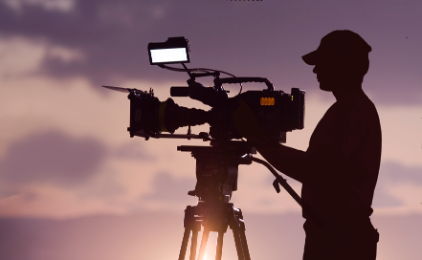

## Overview

This project seeks to recommend Microsoft a business strategy related to launching a movie production studio. Due to the lack of Microsoft's industry knowledge, the below data analysis will interpret the available data to recommend (i) the top movie production companies to replicate, (ii) movie genres to invest in and (iii) target budgets and return on investments. Microsoft will be able to ultimately use this analysis to identify the necessary investment strategies to apply to their first productions.

## Business Problem

Microsoft's business problem largely involves entering the large, global industry of film and lack of experience in the movie production industry. Although Microsoft itself is a substantial firm with numerous resources, the film industry has many barriers of industry heavily dependent on industry experience and scale. Microsoft currently offers rental movies on its site for users but has never produced a film. It is crucial for Microsoft to selectively choose what films to produce as this could make or break the program.

## Data Understanding

For purposes of this analysis we will be utilizing IMDB's data set which provides for movie genres,  Box Office Mojo's data set (powered by IMDB Pro) which provides production studio data, and The Numbers data set which gives access to worldwide gross sales data and release years.

In [37]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
from plotly.subplots import make_subplots
import plotly.express as px 

First, we will import any libraries necessary for this analysis and open the relevant files.

The files loaded below contain a various amount of information regarding movies which include movie titles, production studios, production budgets, gross sales data (worldwide and domestic), ratings data and more.

In [38]:
#Utilizing pd.read_csv to open the CSV file
df_bow = pd.read_csv("zippedData/bom.movie_gross.csv.gz")
df_bow.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [39]:
#Utilizing pd.read_csv to open the CSV file
df_tn = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")
df_tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [40]:
#Utilizing sqlite to open the db
conn = sqlite3.connect('zippedData/im.db')
df_imdb_movie_basics = pd.read_sql("""SELECT * FROM movie_basics;""", conn)
df_imdb_movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [41]:
#Utilizing pd.read_sql to open the SQL file
df_imdb_movie_ratings = pd.read_sql("""SELECT * FROM movie_ratings;""", conn)
df_imdb_movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


## Data Preparation

The below data preparations include creating various data frames from three of the files that were opened (Box Office Mojo, The Numbers, and IMDB). Here, I've made three separate data frames that highlight the top 8 studios by volume of movie production combined with the production budget from The Numbers data set, as well as creating a data set of the combined IMDB data. Ultimately, the IMDB data frame will be combined with the 'Top 8 Studios' and 'The Numbers' data frames to create one large, aggregated data frame.

Combining this data in all one data frame will help with visualizing the available data in one place and ultimately aid with the data cleaning process.

### Create a Dataframe of the Top 8 Studios with the Most Movies Produced

In [42]:
#Create a list of the top 8 production studios through .value_counts()
list(df_bow['studio'].value_counts().head(8).index)

['IFC', 'Uni.', 'WB', 'Fox', 'Magn.', 'SPC', 'Sony', 'BV']

In [43]:
#Utilize the above list and.loc[] to create a data frame only including our top 8 production studios
top_studios_df = df_bow.loc[(df_bow['studio'] == 'IFC') | (df_bow['studio'] == 'Uni.') | \
(df_bow['studio'] == 'WB') | (df_bow['studio'] == 'Magn.') | (df_bow['studio'] == 'Fox') | \
(df_bow['studio'] == 'SPC') | (df_bow['studio'] == 'Sony') | (df_bow['studio'] == 'BV')]

#Use .groupby() to organize the data frame by production studio
top_studios_df.groupby('studio').count()

,title,domestic_gross,foreign_gross,year
studio,,,,
BV,106,106,104,106
Fox,136,136,134,136
IFC,166,166,68,166
Magn.,136,136,55,136
SPC,123,123,59,123
Sony,110,109,106,110
Uni.,147,147,144,147
WB,140,140,130,140


### Create a Dataframe of the Numbers Data (Production Budget, Sales)

In [44]:
#Utilize .str.split to split the release_date column to seperate 'month_date' and 'year' columns
df_time_tn = df_tn['release_date'].str.split(",", expand=True)
df_time_tn = df_time_tn.rename(columns = {0 : 'month_date'})
df_time_tn = df_time_tn .rename(columns = {1 : 'year'})

In [45]:
#Join the separated month_date, year data frame with our original 'the numbers' data frame
df_tn = df_tn.join(df_time_tn, how = 'outer')

#Drop columns that woon't be used
df_tn = df_tn.drop(['id', 'release_date', 'month_date'], axis = 1)

#Rename the 'movie' column name to 'title'
df_tn = df_tn.rename(columns = {'movie' : 'title'})

In [46]:
#Define a function that will convert a string containing '$' and commas to an integer
def change(L):
    char_to_replace= {'$': '', ',': ''}
    for key, value in char_to_replace.items():
        L = L.replace(key, value)
    t = int(L)            
    return t

In [47]:
#Apply the above function to the columns that need to be converted to integers
df_tn['production_budget'] = df_tn['production_budget'].map(change)
df_tn['domestic_gross']= df_tn['domestic_gross'].map(change)
df_tn['worldwide_gross']= df_tn['worldwide_gross'].map(change)
df_tn[['year']] = df_tn[['year']].apply(pd.to_numeric)

### Combine Top 5 Studios DF with Numbers Data

In [48]:
#Use .drop() to remove any unnecessary columns
top_studios_df = top_studios_df.drop(['domestic_gross', 'foreign_gross'], axis = 1)

#Use .merge() to combine our top_studios data frame and numbers data frame based on 'title' and 'year'
top_studios_tn_df = pd.merge(top_studios_df, df_tn, how = 'right', on = ['title', 'year'])

#Identify any N/A values
top_studios_tn_df.isna().sum()

#Drop any N/As that are found in the 'studio' column
top_studios_tn_df = top_studios_tn_df.dropna(subset = ['studio'])

#Check if there are any N/A values after dropping
top_studios_tn_df.isna().sum()

title                0
studio               0
year                 0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

### Join the Two IMDB Data Frames

In [49]:
#Create a SQL query to combine the two IMDB data frames

q = """
SELECT *
FROM movie_basics
JOIN movie_ratings
    ON movie_basics.movie_id = movie_ratings.movie_id
;
"""

imdb_movie_agg_df = pd.read_sql(q, conn)

In [50]:
#Drop the irrelevant columns
imdb_movie_agg_df = imdb_movie_agg_df.drop(['original_title', 'movie_id'], axis=1)

#Rename 'primary_title' to 'title' and 'start_year' to 'year' so that this matches our other dataframes
imdb_movie_agg_df = imdb_movie_agg_df.rename(columns = {'primary_title' : 'title'})
imdb_movie_agg_df = imdb_movie_agg_df.rename(columns = {'start_year' : 'year'})

#Preview the dataset
imdb_movie_agg_df.head()

,title,year,runtime_minutes,genres,averagerating,numvotes
0,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43
2,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


### Join the IMDB Data Frame and Top Studios w/ Numbers

In [51]:
#Merge our aggregated IMDB data frame and top studios with numbers data frame
imdb_studios_tn_df = pd.merge(imdb_movie_agg_df, top_studios_tn_df, how = 'inner', \
                              on = ['title', 'year'])

#Check this joined data frame's info
imdb_studios_tn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 486 entries, 0 to 485
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              486 non-null    object 
 1   year               486 non-null    int64  
 2   runtime_minutes    485 non-null    float64
 3   genres             485 non-null    object 
 4   averagerating      486 non-null    float64
 5   numvotes           486 non-null    int64  
 6   studio             486 non-null    object 
 7   production_budget  486 non-null    int64  
 8   domestic_gross     486 non-null    int64  
 9   worldwide_gross    486 non-null    int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 41.8+ KB


### Data Cleaning

Thus far, we have created and joined three separate data frames. Now, we will begin the cleaning process. Given our above .info() check did not show any 'null' values, we can now check if there are any repeat inputs by movie title and remove any duplicates.

#### Identify/Remove Duplicate Movies

In [52]:
#Utilize a function which concates a data frame of movie titles with duplicate entries
pd.concat(g for _, g in imdb_studios_tn_df.groupby("title") if len(g) > 1)

,title,year,runtime_minutes,genres,averagerating,numvotes,studio,production_budget,domestic_gross,worldwide_gross
349,Coco,2017,105.0,"Adventure,Animation,Comedy",8.4,277194,BV,175000000,209726015,798008101
350,Coco,2017,98.0,Horror,7.4,35,BV,175000000,209726015,798008101
92,Leap Year,2010,100.0,"Comedy,Romance",6.5,86125,Uni.,19000000,25918920,32618920
93,Leap Year,2010,94.0,"Drama,Romance",5.9,2211,Uni.,19000000,25918920,32618920
58,The Bounty Hunter,2010,110.0,"Action,Comedy,Romance",5.6,112444,Sony,45000000,67061228,135808837
59,The Bounty Hunter,2010,NaN,None,6.3,29,Sony,45000000,67061228,135808837


In [53]:
#Remove the duplicates based on their location
imdb_studios_tn_df = imdb_studios_tn_df.drop(labels=93, axis=0)
imdb_studios_tn_df = imdb_studios_tn_df.drop(labels=350, axis=0)
imdb_studios_tn_df = imdb_studios_tn_df.drop(labels=59, axis=0)

imdb_studios_tn_df.shape

(483, 10)

Since our analysis will ultimately review each movie's genre, we will now separate the 'genres' column by three separate classifications and check if there are any genre names that can be aggregated under one classification. We then can check if all three genre columns are necessary, or if any could be removed.

Our analysis will also need to analyze each movie's return on investment (ROI). Therefor, we will add an ROI column which runs a formula based on the worldwide gross sales and production budget data that is available.

#### Edit Genres, Organize into Main Genres vs. Sub Genres

In [54]:
#Utilize .str.split() so that we can separate the 'genres' column to its own data frame
test_df = imdb_studios_tn_df['genres'].str.split(",", expand=True)
test_df = test_df.rename(columns = {0 : 'genre_1'})
test_df = test_df.rename(columns = {1 : 'genre_2'})
test_df = test_df.rename(columns = {2 : 'genre_3'})
test_df

,genre_1,genre_2,genre_3
0,Adventure,Comedy,Drama
1,Action,Crime,Drama
2,Action,Adventure,Sci-Fi
3,Comedy,Family,None
4,Adventure,Animation,Comedy
...,...,...,...
481,Horror,Thriller,None
482,Biography,Drama,Thriller
483,Biography,Comedy,Drama
484,Documentary,None,None


In [55]:
#Join this genres data frame with our original datafrme
imdb_studios_tn_df = imdb_studios_tn_df.join(test_df, how = 'outer')

In [56]:
#Fill any N/As in the 'gennre_2' column with the input that is in genre_1
imdb_studios_tn_df['genre_2'] = imdb_studios_tn_df['genre_2'].fillna(imdb_studios_tn_df['genre_1'])

#### Replace All 'Biography' with 'Documentary'

In [57]:
#Conform the 'Biography' genres in each column to all clasify as 'Documentary'
imdb_studios_tn_df.loc[(imdb_studios_tn_df['genre_1'] == 'Biography'),'genre_1']='Documentary'
imdb_studios_tn_df.loc[(imdb_studios_tn_df['genre_2'] == 'Biography'),'genre_2']='Documentary'
imdb_studios_tn_df.loc[(imdb_studios_tn_df['genre_3'] == 'Biography'),'genre_3']='Documentary'

In [58]:
#Conform the 'Music' genres in each column to all clasify as 'Musical'
imdb_studios_tn_df.loc[(imdb_studios_tn_df['genre_2'] == 'Music'),'genre_2']='Musical'
imdb_studios_tn_df.loc[(imdb_studios_tn_df['genre_3'] == 'Music'),'genre_3']='Musical'

In [59]:
#If the 'genre_2' genre is the same as 'genre 1', replace the 'genre 2' genre with '-'
imdb_studios_tn_df.loc[(imdb_studios_tn_df['genre_2'] == imdb_studios_tn_df['genre_1']),'genre_2']='-'
imdb_studios_tn_df = imdb_studios_tn_df.drop('genre_3', axis = 1)

#Drop our 'genres' column
imdb_studios_tn_df = imdb_studios_tn_df.drop(['genres'], axis = 1)

#Create a new 'genres' column that concatenates our new 'genre_1' with 'genre_2'
imdb_studios_tn_df['genres'] = imdb_studios_tn_df['genre_1'] + ', ' + imdb_studios_tn_df['genre_2']

#### Add a Column of ROIs

Source for calculating ROI: https://www.linkedin.com/pulse/how-can-one-calculate-roi-when-investing-movies-sharad-patel/

In [60]:
#Add a new ROI(percentage) column that is based on the formula described in the above article
imdb_studios_tn_df['ROI_(percentage)'] = (imdb_studios_tn_df['worldwide_gross'] \
                                        /imdb_studios_tn_df['production_budget'])* 100
imdb_studios_tn_df.head()

,title,year,runtime_minutes,averagerating,numvotes,studio,production_budget,domestic_gross,worldwide_gross,genre_1,genre_2,genres,ROI_(percentage)
0,The Secret Life of Walter Mitty,2013,114.0,7.3,275300,Fox,91000000,58236838,187861183,Adventure,Comedy,"Adventure, Comedy",206.440860
1,A Walk Among the Tombstones,2014,114.0,6.5,105116,Uni.,28000000,26017685,62108587,Action,Crime,"Action, Crime",221.816382
2,Jurassic World,2015,124.0,7.0,539338,Uni.,215000000,652270625,1648854864,Action,Adventure,"Action, Adventure",766.909239
3,The Three Stooges,2012,92.0,5.1,28570,Fox,30000000,44338224,54052249,Comedy,Family,"Comedy, Family",180.174163
4,Tangled,2010,100.0,7.8,366366,BV,260000000,200821936,586477240,Adventure,Animation,"Adventure, Animation",225.568169


## Data Analysis

### Show Top 10 Studios by Number of Movies Produced

The below data frame groups our data frame by production studio in order to analyze the top eight production studios based on total movies produced through a Plotly bar chart.

In [61]:
#Create a top 10 Studios data frame, grouped by studio and showing the movie counts
top_10_studios = imdb_studios_tn_df.groupby('studio').count()
top_10_studios

,title,year,runtime_minutes,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,genre_1,genre_2,genres,ROI_(percentage)
studio,,,,,,,,,,,,
BV,70,70,70,70,70,70,70,70,70,70,70,70
Fox,103,103,103,103,103,103,103,103,103,103,103,103
IFC,8,8,8,8,8,8,8,8,8,8,8,8
Magn.,8,8,8,8,8,8,8,8,8,8,8,8
SPC,19,19,19,19,19,19,19,19,19,19,19,19
Sony,68,68,68,68,68,68,68,68,68,68,68,68
Uni.,112,112,112,112,112,112,112,112,112,112,112,112
WB,95,95,95,95,95,95,95,95,95,95,95,95


In [62]:
#Create a bar chart using plotly to show case the top 10 studios by movie count
fig = px.bar(top_10_studios, x = list(top_10_studios.iloc[:, 0].index),  y = 'title', 
             title = "Total Movies Produced by Production Studios",
             labels = {'title': 'Number of Movies', 'x': 'Production Studio'},
             color_discrete_sequence=[px.colors.qualitative.Plotly])
fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    barmode='stack', xaxis={'categoryorder':'total descending'})
fig.update_layout()
fig.show()

### Show Top 10 Studios by Median ROI

The below data frame also groups our data frame by production studio but now, will be used to analyze the top eight production studios based on the production studios' median return on investment through a Plotly bar chart.

In [63]:
#Create a data frame of the top 10 studios by median in order to create the below graph
top_10_studios_mean = imdb_studios_tn_df.groupby('studio').median()
top_10_studios_mean

,year,runtime_minutes,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,ROI_(percentage)
studio,,,,,,,,
BV,2014.0,117.0,7.1,206168.5,150000000.0,140451743.5,279853106.0,310.769105
Fox,2014.0,106.0,6.4,95318.0,58000000.0,65014513.0,165720921.0,277.242173
IFC,2013.5,100.0,6.3,25595.5,2500000.0,391642.5,923687.5,26.785371
Magn.,2010.0,99.0,6.4,39193.5,5750000.0,278293.0,1045462.0,39.809127
SPC,2011.0,109.0,7.3,65304.0,8000000.0,4033574.0,20005613.0,228.318773
Sony,2013.0,104.0,6.3,106103.0,55000000.0,78398803.0,191678378.0,293.098748
Uni.,2014.0,108.0,6.3,115787.5,40000000.0,63775337.5,125970792.5,333.119747
WB,2014.0,113.0,6.6,123955.0,58000000.0,60457138.0,130673154.0,218.282005


In [64]:
#Create a bar chart using plotly to show case the top 10 studios by median ROI
fig = px.bar(top_10_studios_mean, x = list(top_10_studios_mean.iloc[:, 0].index),  y = 'ROI_(percentage)', 
             title = "Median ROI by Production Studio",
             labels = {'ROI_(percentage)': 'Median ROI', 'x': 'Production Studio'},
             color_discrete_sequence=[px.colors.qualitative.Plotly])

fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    barmode='stack', xaxis={'categoryorder':'total descending'})

fig.update_layout()
fig.show()

### Show Top 5 Studios by Number of Movies Produced

The below data frame groups our data frame by the top five production companies previously identified and is also grouped by genre. The data frame will ultimately be used through a bar chart that visualizes how many movies were produced and classified by genre and the production studio.

In [65]:
#Creat a top 5 studios data frame
top_5_studios = imdb_studios_tn_df.loc[(imdb_studios_tn_df['studio'] == 'Uni.') | \
(imdb_studios_tn_df['studio'] == 'WB') | (imdb_studios_tn_df['studio'] == 'Fox') | \
(imdb_studios_tn_df['studio'] == 'Sony') | (imdb_studios_tn_df['studio'] == 'BV')]

#Groupby studio and genre_1 and take the count
top_5_studios_group = top_5_studios.groupby(['studio', 'genre_1']).count()

#Reset the index so we can accurately graph the below data frame
top_5_studios_genre_chart = top_5_studios_group.reset_index()
top_5_studios_genre_chart.head()

,studio,genre_1,title,year,runtime_minutes,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,genre_2,genres,ROI_(percentage)
0,BV,Action,26,26,26,26,26,26,26,26,26,26,26
1,BV,Adventure,23,23,23,23,23,23,23,23,23,23,23
2,BV,Animation,1,1,1,1,1,1,1,1,1,1,1
3,BV,Comedy,8,8,8,8,8,8,8,8,8,8,8
4,BV,Documentary,7,7,7,7,7,7,7,7,7,7,7


In [66]:
#Utilize ther above data frame for when we graph just the top 5 studios by count
top_5_studios_bar_chart = top_5_studios.groupby('studio').count()
top_5_studios_bar_chart

,title,year,runtime_minutes,averagerating,numvotes,production_budget,domestic_gross,worldwide_gross,genre_1,genre_2,genres,ROI_(percentage)
studio,,,,,,,,,,,,
BV,70,70,70,70,70,70,70,70,70,70,70,70
Fox,103,103,103,103,103,103,103,103,103,103,103,103
Sony,68,68,68,68,68,68,68,68,68,68,68,68
Uni.,112,112,112,112,112,112,112,112,112,112,112,112
WB,95,95,95,95,95,95,95,95,95,95,95,95


In [67]:
#Graph the top 5 studios by count
fig = px.bar(top_5_studios_bar_chart, x = list(top_5_studios_bar_chart.iloc[:, 0].index),  y = 'title',
             title = "Top 5 Performing Studios by Movie Production",
             labels = {'x': 'Production Studio', 'title': 'Number of Movies'},
             color_discrete_sequence=[px.colors.qualitative.Plotly])

fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
         barmode='stack', xaxis={'categoryorder':'total descending'})

fig.show()


### Show Top 5 Studios by Production and Genre

The below data frame groups our data frame by the top five production companies previously identified and is also grouped by genre. The data frame will ultimately be used through a bar chart that visualize how many movies were produced classified by genre and the production studio.

In [68]:
#Create a bar chart which highlights the number of movies produced by movie genre and top 5 studios
fig = px.bar(top_5_studios_genre_chart, x = 'genre_1',  y = 'title', color = 'studio', 
             title = "Total Movie Genres Produced by Top Production Studios",
             labels = {'genre_1': 'Movie Genre', 'title': 'Number of Movies', 'studio': "Studio"})

fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
        barmode='stack', xaxis={'categoryorder':'total descending'})

fig.show()


### Show Top Production Studios and Genres by Distribution of Movie Budget

The below data frame now groups our data frame by the top five production companies previously identified, the top three genres, and the distribution of movie budgets. The data frame will be visualized through a box chart.

In [69]:
#Create a data frame of the top 5 studios by median in order to create the below graph
top_genres = top_5_studios.loc[(top_5_studios['genre_1'] == 'Action') | (top_5_studios['genre_1'] == 'Adventure') | \
                               (top_5_studios['genre_1'] == 'Comedy')]



In [70]:
#Create a box plot with Ploty which highlights the distribution of movie budget \
#produced by top genres and top studios

fig = px.box(data_frame = top_genres, x= 'production_budget', color = 'genre_1', facet_col = 'studio',
                title = "Distribution of Movie Budget by Top Studios and Genres",
                width=1060, height=400, facet_col_wrap=5,
                labels = {'production_budget': 'Production Budget', 'production_budget': 'Production Budget', 
                          'production_budget': 'Production Budget', 'genre_1': 'Movie Genre'})
             
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.update_layout(xaxis_title='Production Budget',
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig['layout']['xaxis1']['title']['text'] = ''
fig['layout']['xaxis2']['title']['text'] = ''
fig['layout']['xaxis4']['title']['text'] = ''
fig['layout']['xaxis5']['title']['text'] = ''


fig.show()



### Show Top Production Studios and Genres by Distribution of Movie ROI

Similar to the graph above, we are grouping our data frame by the top five production companies, the top three genres, and now by the distribution of movie ROIs. This data frame will also be visualized through a box chart.

In [71]:
#Create a box plot with Ploty which highlights the distribution of ROI
#produced by top genres and top studios

fig = px.box(data_frame = top_genres, x= 'ROI_(percentage)', color = 'genre_1', facet_col = 'studio',
                title = "Distribution of Movie ROI by Top Studios and Genres",
                width=1060, height=400, facet_col_wrap=5,
                labels = {'ROI_(percentage)': 'ROI (percentage)', 'ROI_(percentage)': 'ROI (percentage)', 
                          'ROI_(percentage)': 'ROI (percentage)', 'genre_1': 'Movie Genre'})
             
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.update_layout(xaxis_title='ROI (percentage)',
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

fig['layout']['xaxis1']['title']['text'] = ''
fig['layout']['xaxis2']['title']['text'] = ''
fig['layout']['xaxis4']['title']['text'] = ''
fig['layout']['xaxis5']['title']['text'] = ''


fig.show()



### Show Top Production Studios and Genres by the Relationship between Movie Budget and ROI

The last visualization will be a scatter plot. To create the visual will again utilize our top_genres data frame but will now visualize the top production companies, the top genres, and the relationship between movie budgets and ROIs.

In [72]:
#Create a scatter plot with Ploty which highlights the distribution of ROI and production budget
#produced by top genres and top studios
fig = px.scatter(data_frame = top_genres, x="production_budget", y="ROI_(percentage)", color='genre_1',
                facet_col = 'studio',
                title = "Production Company ROI Relative to Budget and Top Genres",
                width=1000, height=400, facet_col_wrap=5,
                labels = {'production_budget': 'Production Budget', 'production_budget': 'Production Budget', 
                          'production_budget': 'Production Budget', 'ROI_(percentage)': 'ROI (percentage)',
                         'genre_1': 'Movie Genre'})
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig['layout']['xaxis']['title']['text'] = ''
fig['layout']['xaxis2']['title']['text'] = ''
fig['layout']['xaxis4']['title']['text'] = ''
fig['layout']['xaxis5']['title']['text'] = ''
fig.update_traces(marker=dict(size=10),
                  selector=dict(mode='markers'))
fig.show()               

# Conclusion

This analysis leads to three recommendations for improving operations of Microsoft’s Movie Studios:

- **Consider employing both BV (Disney’s) and Universal Studio’s business and production strategies.** Considering the volume of movies produced and median ROI, Disney and Universal Studio are consistently the front runner of the industry.
- **Mostly invest in action and comedy movies.** Given comedy tends to have a smaller distribution of production budgets and relatively consistently high ROI, Microsoft should produce comedy films as their first few projects. As productions are rolled-out, Microsoft can then produce more action films as these too have relatively higher ROIs but tend to have a wider distribution in terms of project budget. 
- **Target low budgets and high ROIs.** Given there is no clear linear correlation related to project budget size and return on investment, Microsoft should consider producing projects with lower budgets (<$100m) as these tend to produce relatively high ROIs (~500%).

# Next Steps

Further analyses could yield additional insights to further inform Microsoft’s movie production strategy:

- **More recent data sets to analyze the most up-to-date movie production trends.** These insights rely upon movies that were released between 2010 and 2018. In order to analyze the most recent movie production projects, a more recent data set representing films released during 2019 or after could result in more accurate analyses.
- **More time to analyze which sub-genres are most invested in.** Given the time constraint of this presentation, an analysis of sub-genre investments by top production companies could further assist Microsoft in deciding, for example, which types of comedy films the firm should invest in.
- **Refined calculation of ROI. The analyses of ROI in this assumes a relatively simple calculation.** With a larger data set that include production budget breakdowns and expense line items could result in more accurate ROI representations. 